# Big Data and Machine Learning in Healthcare Applications

## HW4

[Operational data challenge](https://medicalanalytics.group/operational-data-challenge)
We would like to invite all interested in machine learning and operational research to explore our operational dataset. You can download it from here:

Data only (zipped Excel file, 53MB)
Code and data (zipped code and Excel file, 63MB)
This data, describing patient waits in a hospital, was built for the following challenges (see our recent publication here: https://rdcu.be/b4ffC):

Predict patient wait times from the other operational features, as accurately as possible
Identify the smallest subset of features, sufficient for accurate wait time prediction across all four facilities in the dataset. The smallest model MAE should be at most 1-2 minutes worse compared to the best full model MAE
Invent (engineer) new features significantly improving model prediction quality
Overall, reducing MAE by more than 70% in comparison with the simple intercept model (predicting wait from its overall average) would be a significant step forward.

In [93]:
from pathlib import Path

import re
import itertools
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable, Union
%matplotlib inline

## Read Data

In [94]:
data_path = Path("../input")
file_stem = "WaitData.Published"
try:
    df = pd.read_pickle(data_path/f"{file_stem}.pkl")
except FileNotFoundError:
    # only interested in tab F3
    df = pd.read_excel(data_path/f"{file_stem}.xlsx", sheet_name="F3")
    pd.to_pickle(df, data_path/f"{file_stem}.pkl")

In [95]:
print(f"{len(df)} records in our data")

23583 records in our data


In [96]:
df.describe()

,Wait,SumHowEarlyWaiting,AvgHowEarlyWaiting,LineCount0Strict,SumWaits,LineCount0,LineCount1,LineCount2,LineCount3,LineCount4,...,NumAddOnsToday,NumAddOnsLastW2,NumScheduledNextSlot,NumScheduledNextW2,SumTimeToCompleteNextSlot,SumTimeToCompleteNextW2,WithContrastCountWaiting,WithAndWithoutContrastCountWaiting,WithContrastCountInProgress,WithAndWithoutContrastCountInProgress
count,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000,...,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000
mean,8.399864,328.280414,60.758937,3.693126,199.039308,5.264089,5.195056,5.080736,4.954204,4.802146,...,1.538820,0.599627,1.683119,1.984777,28.728915,32.245007,3.651529,0.536107,0.863164,0.187678
std,48.299114,203.227527,28.412621,2.506477,140.087363,2.610587,2.684927,2.788963,2.885722,2.978372,...,2.037477,0.886572,0.558773,1.381474,10.807578,22.962655,2.095205,0.757206,0.864823,0.427678
min,-497.000000,-150.000000,-82.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-12.000000,180.000000,45.000000,2.000000,95.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,0.000000,0.000000,1.000000,1.000000,17.000000,16.000000,2.000000,0.000000,0.000000,0.000000
50%,12.000000,306.000000,60.000000,3.000000,175.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,0.000000,2.000000,2.000000,30.000000,30.000000,4.000000,0.000000,1.000000,0.000000
75%,34.000000,450.000000,75.000000,5.000000,279.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,2.000000,1.000000,2.000000,3.000000,35.000000,47.000000,5.000000,1.000000,1.000000,0.000000
max,360.000000,1563.000000,487.000000,14.000000,1032.000000,17.000000,18.000000,17.000000,18.000000,15.000000,...,13.000000,7.000000,6.000000,8.000000,121.000000,136.000000,13.000000,6.000000,6.000000,3.000000


## Problem description

Time for building more models! – and now, after learning how to find and engineer their features, we
can really look into using the most efficient, interpretable predictions. Model Interpretability is
particularly appreciated in healthcare, where we want to understand why certain thing happen.
Selecting the best short models is one of the best approaches to interpretability.
Getting the data: Please go to this ”Data Challenge” web page,
https://medicalanalytics.group/operational-data-challenge/
and click on the “Data only” link there to download the data 1 .
In the sheet, use F3 tab (dataset) ONLY: delete F1, F2 and F4, to load faster in Python. Also, drop all
variables with names prefixed with x_ (these are the original timestamps, they make very little sense as
model features).
Wait will be our target variable we want to predict/model.
The last sheet in this file explains the features – most of them were engineered, and you should
understand how by now. But there are tons of them, and we have to sort this out.
Fitting the model: We can explore different machine learning models, but let’s pick linear regression,
since it takes little time to compute. So if Y is the Wait, and X – everything else, you can fit regression
with this code:

from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X, Y)
Ypred = model.predict(X) # use trained regression model to predict
r = Y-Ypred # compute prediction error (residual)
e = abs(r).mean() # compute model error


## Baseline MAE

In [97]:
mean_wait_time = df["Wait"].mean()
print(f"Mean Wait Time: {mean_wait_time}")
baseline_mae = metrics.mean_absolute_error(df["Wait"], [mean_wait_time]*len(df))
print(f"Baseline MAE is {baseline_mae}")

Mean Wait Time: 8.39986430903617
Baseline MAE is 32.51193817013356


According to the problem description, the target MAE should be below .3* MAE of intercept model.

In [98]:

f"Target Test MAE is below {.3*baseline_mae}"

&#39;Target Test MAE is below 9.753581451040068&#39;

## Clean data

First we will start by breaking date fields down into useful features, such as day, day of week etc. This may be a bit redundant here as many of the features generated already exist in the data, however as our base model is random forest which creates de-correlated trees, auto-correlation should not be an issue.

In [99]:
def make_date(df, date_field):
    "Make sure `df[date_field]` is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)
        
        
def add_datepart(df, field_name, prefix=None, drop=True, time=False):
    "Helper function that adds columns relevant to a date in the column `field_name` of `df`."
    make_date(df, field_name)
    field = df[field_name]
    if not prefix:
        prefix = re.sub('[Dd]ate$', '', field_name)
    attr = ['Year', 'Month', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[prefix + n] = getattr(field.dt, n.lower())
    # Pandas removed `dt.week` in v1.1.10
    week = field.dt.isocalendar().week if hasattr(field.dt, 'isocalendar') else field.dt.week
    df.insert(3, prefix+'Week', week)
    mask = ~field.isna()
    df[prefix + 'Elapsed'] = np.where(mask,field.values.astype(np.int64) // 10 ** 9,None)
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

data = df.fillna(0) #Simple imputation of missing values to 0, may want to review this

# splitting date variables in to components
data = add_datepart(data, 'x_ArrivalDTTM')
data = add_datepart(data, 'x_ScheduledDTTM')
data = add_datepart(data, 'x_BeginDTTM')

In [100]:
## Questions:
## MAE - where is the test data? What is stopping us overfitting here
## Do we need to consider the data is longitudinal, ie should our test
## set be the latest n records?
data = df.loc[:,~df.columns.str.startswith('x_')]
len(data)
X = data.iloc[:,1:]
y = data.iloc[:,0]
len(X), len(y)

(23583, 23583)

Creating Training / Validation / Test splits of 60/20/20.

For random forest an explicit validation set may not be necessary as we have the Out of Bag Error, however we will use this as a sanity test.

The variable sample_random controls whether we want to treat this as a longitudinal problem where the goal is to use the model to predict future wait times. If so, we are using the latest data for testing to account for data drift.

In [101]:
## Create train test splits 60/20/20
sample_random = False
if sample_random:
    trainval_X, test_X, trainval_y, test_y = train_test_split(X,y,test_size=0.2, random_state=42, shuffle=True)
    train_X, valid_X, train_y, valid_y = train_test_split(trainval_X,trainval_y,test_size=0.25, random_state=42)
    len(train_y), len(valid_y), len(test_y)
else:
    test_X,test_y = X.iloc[:int(len(X)*.2),:], y[:int(len(y)*.2)]
    valid_X,valid_y = X.iloc[int(len(X)*.2):int(len(X)*.4),:], y[int(len(X)*.2):int(len(y)*.4)]
    train_X,train_y = X.iloc[int(len(X)*.4):,:], y[int(len(y)*.4):]

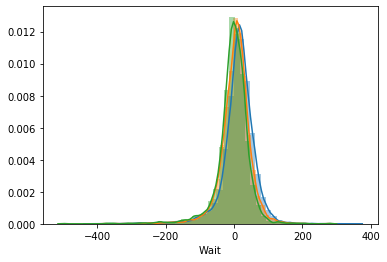

In [102]:
fig, ax = plt.subplots()

sns.distplot(train_y, ax=ax)
sns.distplot(valid_y, ax=ax)
sns.distplot(test_y, ax=ax)
plt.show()

From above, for random sampling, we can see that wait is representative across splits, although this should be expected as the sampling is random and theoretically representative of the population.

For longitudinal sampling, we can see a slight shift of wait times, although it mostly overlaps suggesting little change to wait times over time.


In [103]:
def rf(xs, y):
    return RandomForestRegressor(n_jobs=-1, oob_score=True).fit(xs, y)

In [104]:
m = rf(train_X, train_y)

In [105]:
def m_mae(m, xs, y): return metrics.mean_absolute_error(m.predict(xs), y)

m_mae(m, train_X, train_y), m_mae(m, valid_X, valid_y)

(8.836597137809186, 23.829964772807575)

Our training error is much lower than the validation set implying heavy overfitting. For this notebook, we will fit a simple random forest with no hyperparameter tuning to explore the data a little, however in the final models we will look at ways to fix this.

In [106]:
preds = np.stack([t.predict(valid_X) for t in m.estimators_])

In [107]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred), axis=0)
print(mae(preds.mean(0), valid_y.to_list()))

23.829964772807575


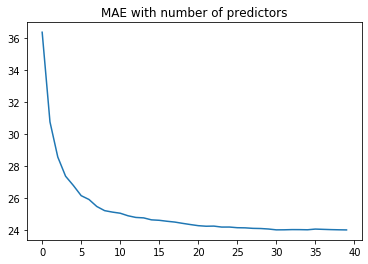

In [108]:
plt.plot([mae(preds[:i+1].mean(0), valid_y) for i in range(40)])
plt.title("MAE with number of predictors")
plt.show()

After around 4-5 parameters, the model does not improve significantly and above 10 would propably be considered overfitting.

In [109]:
mae(m.oob_prediction_, train_y)

23.987505226790276

## Tree variance (confidence in predictions)

[]

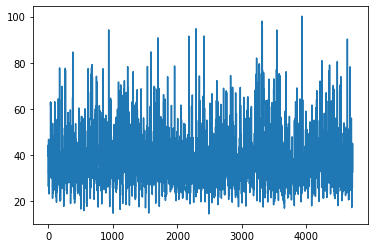

In [110]:
preds_std = preds.std(0)
plt.plot(preds_std)
plt.plot()

We can see very large variance in predictions between trees

## Feature Importance

In [111]:

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [112]:

fi = rf_feat_importance(m, train_X)
fi[:10]

,cols,imp
19,AheadCount,0.144648
2,LineCount0Strict,0.068170
15,DelayCount,0.063343
49,DelayedInLine,0.055079
62,NumCompletedToday,0.049803
40,StartTime4,0.046802
39,StartTime3,0.046161
37,StartTime,0.043358
38,StartTime2,0.041648
50,SumDelayWaitingByExamCode,0.020459


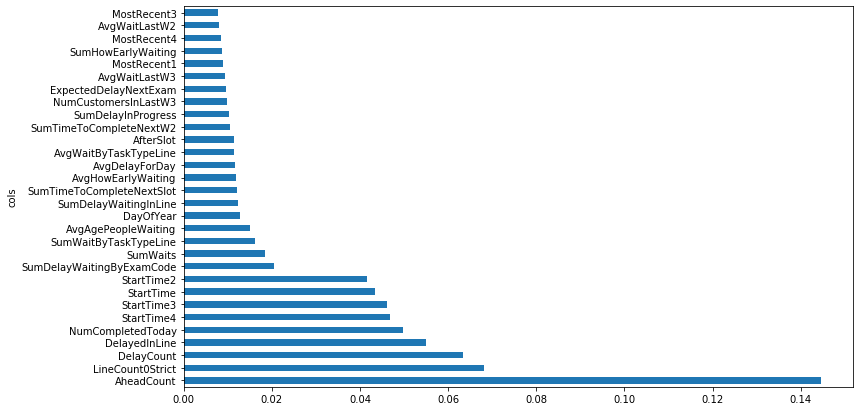

In [113]:

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);


In [114]:

to_keep = fi[fi.imp>0.05].cols
len(to_keep)

4

In [115]:
xs_imp = train_X[to_keep]
valid_xs_imp = valid_X[to_keep]

In [116]:
m = rf(xs_imp, train_y)
m_mae(m, xs_imp, train_y), m_mae(m, valid_xs_imp, valid_y)

(15.361609586709777, 31.150210358223756)

Interestingly, the best performing features are not the same as was found during linear regression in the homework. 

The validation error, is somewhat similar to the homework, however as we do not have a test set for the homework, it is very likely overfitting and more useful for explanatory analysis but not predictive analysis.

Let's recycle the class made for homework and see if we can use best subsets on random forest for feature selection. This is a bit redundant as RF already performs something similar, however this is more to test the interface and show extendability of the class to other types of models.

In [117]:
%%time
def rf_model(X, Y):
    "Returning RF model with lowest OOB score as proxy for validation error"
    model = RandomForestRegressor(n_jobs=-1, oob_score=True)
    model.fit(X, Y)
    return {"Error":model.oob_score_, "Model":model, "Params": X.columns}

def ols_model(X, Y):
    "Ordinary Least Squares Regression from HW"
    model = linear_model.LinearRegression()
    model.fit(X, Y)
    Ypred = model.predict(X) # use trained regression model to predict
    e = abs(Y - Ypred).mean()
    return {"Error":e, "Model":model, "Params": X.columns}


class FeatureSelector:
    """ Class to contain feature selection algorithms
        To use this class, models should be defined
        as a function and return a dict containing:
        Error, Model and Params
    """ 
    def __init__(self, model:Callable, X:pd.DataFrame, y:pd.Series) -> None:
        self.model = model
        self.X = X
        self.y = y

    @staticmethod
    def best_model(results:list) -> dict:
        "Returns model with minimum error"
        models = pd.DataFrame(results)
        best_model = models.loc[models['Error'].argmin()]
        return best_model

    def best_subset(self, k:int) -> dict:
        "Returns best model of any k parameters"
        results = [self.model(self.X[list(params)],self.y) \
            for params in itertools.combinations(self.X.columns, k)]
        return FeatureSelector.best_model(results)

    def best_n_subsets(self, n:int) -> list:
        "Returns a list of best subset models for each parameter size upto n"
        return [self.best_subset(k) for k in range(1,n+1)]

    def _forward_selection(self, predictors:list) -> dict:
        "Inner loop of forward selection, find the next best predictor p"
        remaining_predictors = [p for p in self.X.columns if p not in predictors]
        results = [self.model(self.X[list(predictors)+[p]],self.y) for p in remaining_predictors]
        return FeatureSelector.best_model(results)

    def forward_selection(self, n:Union[bool, int]=None) -> list:
        "Find the best model of n parameters using forward selection"
        models, predictors = [], []
        n = (n or len(self.X.columns))
        for _ in range(n): 
            model = self._forward_selection(predictors)
            models.append(model)
            predictors = model["Params"]
        return models

CPU times: user 91 µs, sys: 372 µs, total: 463 µs
Wall time: 801 µs


In [120]:
ols = FeatureSelector(ols_model, train_X, train_y)
ols_fs = ols.forward_selection()

In [121]:
m = ols_fs[-1] #our best 3 feature model
p = m["Params"].to_list()
m_mae(m["Model"], valid_X[p], valid_y)

23.539037869025215